In [1]:
import os, logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from helpers import get_ip_address, has_write_permission, measure_performance, save_numpy_array, export_feature_array, SNPDataSet

### Set variables

In [2]:
data_locations = {
    '223.195.111.31': '/home/jinhyun/data/1kGP',
    '223.195.111.48': '/project/datacamp/team11/data',
    '147.47.44.229': '/home/jinhyun/data/1kGP',
    '147.47.44.93': '/home/jinhyun/data/1kGP',
}

chr_list = [str(x) for x in range(1,23)]
gt_dict = {"0|0" :0, "0|1" : 1, "1|0" : 2, "1|1" : 3 } # genotype dict for converting string-> inteter 

### Validation checks

In [3]:
raw_data_path = data_locations.get(get_ip_address(), '/not_found')
sample_annotation_file = os.path.join(raw_data_path, "igsr-1000 genomes 30x on grch38.tsv")
preprocess_path = os.path.join(raw_data_path, "preprocessed")

assert os.path.exists(preprocess_path), f"Data path not exists: {raw_data_path} OR IP setting is incorrect: {get_ip_address()}"
assert os.path.isfile(sample_annotation_file), f"File not exists : {sample_annotation_file}"
assert has_write_permission(preprocess_path), f"You do not have write permission for {preprocess_path}"

In [4]:
sample_annotation_df = pd.read_csv(sample_annotation_file, sep="\t")
print(f"Read sample annotation info with shape : {sample_annotation_df.shape}")

Read sample annotation info with shape : (3202, 9)


In [5]:
# sample_annotation_df[["Population name","Population code"]].drop_duplicates()

### data loading

In [6]:
target_data_name = "merged" #"merged_support3_variance_0.1" #"merged" #merged_support3_variance_0.01
target_data_file_prefix = os.path.join(preprocess_path, target_data_name) 

In [7]:
snp_dataset = SNPDataSet.from_file(target_data_file_prefix, sample_annotation_df)

print(f"\ngenotype array shape (#samples, #features) : {snp_dataset.genotype_array.shape}")
print(f"sample annotations (#samples, ) : {snp_dataset.sample_annotation_df.shape}")
print(f"variant info dataframe (#features, ): {snp_dataset.variant_info_df.shape}")

Reading data from files /home/jinhyun/data/1kGP/preprocessed/merged_matrix.npy and /home/jinhyun/data/1kGP/preprocessed/merged_variant.csv
Read genotype array of shape (3202, 61599150) and variant info dataframe of shape (61599150, 4)

genotype array shape (#samples, #features) : (3202, 61599150)
sample annotations (#samples, ) : (3202, 9)
variant info dataframe (#features, ): (61599150, 4)


### Save one-hot encoding matrix

In [7]:
genotype_array_onehot = snp_dataset.create_onehot_genotype_array(inplace = False, batch_initialize = False)
print(snp_dataset.genotype_array.shape, genotype_array_onehot.shape)
save_numpy_array(genotype_array_onehot, os.path.join(preprocess_path, f"{target_data_name}_matrix_onehot.npy"))

(3202, 1000) (3202, 1000, 2)
numpy array of shape (#samples, #features) : (3202, 1000, 2) -> saved to /home/jinhyun/data/1kGP/preprocessed/merged_random_1k_matrix_onehot.npy


### Supporting sample count filtering

In [8]:
supporting_sample_count = (snp_dataset.genotype_array != 0).sum(axis = 0)

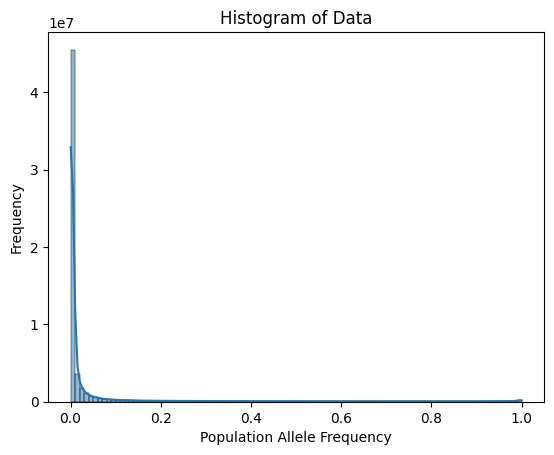

In [9]:
sns.histplot(supporting_sample_count / snp_dataset.genotype_array.shape[0], bins=100, kde=True)  # 'bins' controls the number of bins, 'kde' adds a Kernel Density Estimate plot

#plt.xscale('log')
#plt.xlim(xmin, xmax)

plt.title('Histogram of Data')
plt.xlabel('Population Allele Frequency')
plt.ylabel('Frequency')

plt.show()

In [22]:
supporting_count_filter = (supporting_sample_count >= 3) & (supporting_sample_count <= (snp_dataset.genotype_array.shape[0] - 3))
print(f"This filter will retain {supporting_count_filter.sum()} /", snp_dataset.genotype_array.shape[1], "variants")

This filter will retain 43034818 / 61599150 variants


In [23]:
snp_dataset.filter_variant(supporting_count_filter, inplace = True)

Filter variant retained 43034818 / 61599150


In [24]:
snp_dataset.save_data(os.path.join(preprocess_path, "merged_support3"))

genotype matrix shape (#samples, #features) : (3202, 43034818) -> saved to /home/jinhyun/data/1kGP/preprocessed/merged_support3_matrix.npy
variant info dataframe (#features, ): (43034818, 4) -> saved to /home/jinhyun/data/1kGP/preprocessed/merged_support3_variant.csv


### Feature Selection Based on Variance

In [ ]:
## First creation
#snp_dataset.create_onehot_genotype_array(inplace = True, batch_initialize = True)
#save_numpy_array(snp_dataset.genotype_array_onehot, os.path.join(preprocess_path, "merged_support3_matrix_onehot.npy"))

## Loading from file
snp_dataset.load_onehot_genotype_array(target_data_file_prefix)

In [ ]:
def get_variance_filter(genotype_array_onehot, threshold = 0, batch_process = False):
    # from sklearn.feature_selection import VarianceThreshold
    # selector = VarianceThreshold(threshold = threshold)
    # genotype_array_filtered = selector.fit_transform(genotype_array)
    # mask = selector.get_support()
    # print(f"This filter will return {genotype_array_filtered.shape} /", genotype_array.shape[1], f"variants (")
    # print(f"This filter will retain {mask.sum()} /", genotype_array.shape[1], f"variants (", mask.sum()/genotype_array.shape[1] * 100,"%)")

    if batch_process:
        batch_size=100000
        n_samples, n_snps, feature_dim = genotype_array_onehot.shape
        variances = np.zeros((n_snps, feature_dim))
    
        for start in tqdm(range(0, n_snps, batch_size)):
            end = min(start + batch_size, n_snps)
            batch_var = np.var(genotype_array_onehot[:, start:end, :], axis=0)
            variances[start:end, :] = batch_var
    else:
        variances = np.var(genotype_array_onehot, axis=0)

    mask = (variances > threshold).any(axis=1)
    print(f"Variance filter (threshold = {threshold}) will retain {mask.sum()} /", genotype_array_onehot.shape[1], f"variants (", mask.sum()/genotype_array_onehot.shape[1] * 100,"%)")

    # sns.histplot(variances.reshape(-1), bins=100, kde=True)  # 'bins' controls the number of bins, 'kde' adds a Kernel Density Estimate plot
    # plt.title('Histogram of Data')
    # plt.xlabel('Variances')
    # plt.ylabel('Frequency')
    # plt.show()

    return(mask)

In [ ]:
variance_filter = get_variance_filter(snp_dataset.genotype_array_onehot, threshold=0.1, batch_process = False)

In [ ]:
snp_dataset.filter_variant(variance_filter, inplace = True)

In [ ]:
snp_dataset.save_data(os.path.join(preprocess_path, "merged_support3_variance_0.2499999"))

### 0 filtering

In [ ]:
threshold = 0.0005
zero_ratio = (snp_dataset.genotype_array == 0).sum(axis=0) / snp_dataset.genotype_array.shape[0]

zero_filter = zero_ratio <= threshold
print(f"This filter will retain {zero_filter.sum()} /", snp_dataset.genotype_array.shape[1], "variants")


In [ ]:
snp_dataset.filter_variant(zero_filter, inplace = True)
snp_dataset.save_data(os.path.join(preprocess_path, "merged_zerofilter"))

### Random filteration

In [30]:
n_random_selection = 1000000
random_seed = 42

num_snps = snp_dataset.genotype_array.shape[1]
random_selection_filter = np.zeros(num_snps, dtype=bool)
np.random.seed(random_seed)
selected_indices = np.random.choice(num_snps, n_random_selection, replace=False)
random_selection_filter[selected_indices] = True
print(f"This filter will retain {random_selection_filter.sum()} /", snp_dataset.genotype_array.shape[1], "variants")

#snp_dataset_filtered = snp_dataset.filter_variant(random_selection_filter, inplace = False)
snp_dataset.filter_variant(random_selection_filter, inplace = True)

This filter will retain 1000000 / 2000000 variants
Filter variant retained 1000000 / 2000000


In [31]:
snp_dataset.save_data(os.path.join(preprocess_path, f"{target_data_name}_random_1M_seed_{random_seed}"))

genotype matrix shape (#samples, #features) : (3202, 1000000) -> saved to /home/jinhyun/data/1kGP/preprocessed/merged_support3_random_1M_seed_42_matrix.npy
variant info dataframe (#features, ): (1000000, 4) -> saved to /home/jinhyun/data/1kGP/preprocessed/merged_support3_random_1M_seed_42_variant.csv


### Univariate feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, r_regression, mutual_info_classif
@measure_performance
def uni_feature_selection(X, y, score_func, n = 10000):
    print(f"input array shape : {X.shape}, {y.shape}. n = {n}")
    X_selected = SelectKBest(score_func, k = n).fit_transform(X, y)
    print(f"output array shape : {X_selected.shape}")

    return(X_selected)

n_select = 10000

In [ ]:
X_selected, perf_metrics = uni_feature_selection(X = snp_dataset.genotype_array,
                            y = sample_annotation_df["Population code"],
                            score_func = chi2,
                            n = n_select)
save_numpy_array(X_selected, numpy_save_file_name= os.path.join(preprocess_path,f"{target_data_name}_chi2_10k_matrix.npy"))

In [ ]:
X_selected = uni_feature_selection(X = snp_dataset.genotype_array,
                            y = sample_annotation_df["Population code"],
                            score_func = f_classif,
                            n = n_select)
save_numpy_array(X_selected, numpy_save_file_name= os.path.join(preprocess_path,f"{target_data_name}_f_classif_10k_matrix.npy"))

In [ ]:
X_selected = uni_feature_selection(X = snp_dataset.genotype_array,
                            y = sample_annotation_df["Population code"],
                            score_func = mutual_info_classif,
                            n = n_select)
save_numpy_array(X_selected, numpy_save_file_name= os.path.join(preprocess_path,f"{target_data_name}_mutual_info_classif_10k_matrix.npy"))

### Recurssive feature selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

@measure_performance
def recursive_feature_selection(X, y, n = 10000):
    print(f"input array shape : {X.shape}, {y.shape}. n = {n}")
    knn = KNeighborsClassifier(n_neighbors = n)
    sfs = SequentialFeatureSelector(knn, n_features_to_select = n)
    sfs.fit(X, y)

    #sfs.get_support()
    X_selected = sfs.transform(X)
    print(f"output array shape : {X_selected.shape}")

    return X_selected

In [ ]:
n_select = 100
X_selected = recursive_feature_selection(X = snp_dataset.genotype_array,
                                         y = sample_annotation_df["Population code"],
                                         n = n_select)

#save_numpy_array(X_selected, numpy_save_file_name= os.path.join(preprocess_path,f"{target_data_name}_chi2_10k_matrix.npy"))

### annotation analysis

In [ ]:
sample_annotation_df["Superpopulation code"].value_counts()
sample_annotation_df["Population code"].value_counts()

### Feature engineering

In [ ]:
snp_dataset.create_onehot_genotype_array(inplace = True, batch_initialize = False)
export_feature_array(snp_dataset.genotype_array_onehot, os.path.join(preprocess_path, "merged_random_10k_onehot"))

In [ ]:
import subprocess
def obtain_annovar_annotation(snp_dataset, save_path, annovar_path = "/home/jinhyun/tools/annovar"):
    avinput_file_name = os.path.join(save_path, "temp.avinput")
    annotate_file_prefix = os.path.join(save_path, "temp")
    annotate_file_name = f"{annotate_file_prefix}.hg38_multianno.txt"

    avinput_df = snp_dataset.variant_info_df.copy(deep= True).rename(columns = {"POS" : "START"})
    avinput_df["END"] = avinput_df["START"]
    avinput_df[['CHROM', 'START', 'END', 'REF', 'ALT']].to_csv(avinput_file_name, sep='\t', index=False, header=False)

    
    cmd_run_annovar = f"{annovar_path}/table_annovar.pl {avinput_file_name} {annovar_path}/humandb -buildver hg38 -out {annotate_file_prefix} -remove -protocol refGene,clinvar_20221231,avsnp150,intervar_20180118,gnomad40_genome,esp6500siv2_all,exac03,dbnsfp42c -operation g,f,f,f,f,f,f,f -nastring . " #1000g2015aug
    print("Performing annovar...")
    # print(cmd_run_annovar)
    ret = subprocess.run(cmd_run_annovar, shell=True, text=True, capture_output=True)
    os.remove(avinput_file_name)

    try:
        annotated_df = pd.read_csv(annotate_file_name, sep = "\t", header = 0, na_values=["."], dtype = str)
        os.remove(annotate_file_name)
        print(f"read ANNOVAR annotated result of shape {annotated_df.shape}")
    except:
        print("[warn] could not read annovar result.")
        return None
    
    return(annotated_df)
    

In [ ]:
variant_annot_annovar_df = obtain_annovar_annotation(snp_dataset, save_path=preprocess_path)

In [ ]:
variant_annot_annovar_df["Func.refGene"].value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder

def convert_annotation_into_numpy(df, column_names):
    array_list = []
    for c_name in column_names:
        encoder = LabelEncoder()
        annotation_coded_array = encoder.fit_transform(df[c_name]) #variant_annot_annovar_df['Func.refGene_encoded']
        annotation_coded_array_reshaped = annotation_coded_array.reshape(1, -1, 1)
        array_list.append(annotation_coded_array_reshaped)
        # print(df[c_name].value_counts(), np.unique(annotation_coded_array, return_counts=True))


    merged_array = np.concatenate(array_list, axis = 2)
    print(f"Encoded gene annotation {column_names} and created numpy array of shape {merged_array.shape}")
    return(merged_array)
def merge_genotype_array_with_annotation(gt_array, annot_array):
    assert gt_array.shape[1] == annot_array.shape[1]
    annot_array_repeated = np.repeat(annot_array, gt_array.shape[0], axis=0)

    merged_array = np.concatenate([np.expand_dims(gt_array, axis = 2), annot_array_repeated], axis=2)
    print(f"Obtained merged array of shape {merged_array.shape} from genotype array of shape {gt_array.shape} and annotation array of {annot_array_repeated.shape}")
    return(merged_array)
gene_annotation_array = convert_annotation_into_numpy(variant_annot_annovar_df, ["Func.refGene"]) #"Ref", "Alt", 

save_genotype_array(merge_genotype_array_with_annotation(snp_dataset.genotype_array, gene_annotation_array), os.path.join(preprocess_path, "merged_random_10k_annotated"))


### dimension reduction by PCA and t_SNE

In [ ]:
genotype_array_onehot = snp_dataset.create_onehot_genotype_array(inplace = False, batch_initialize = False)
print(snp_dataset.genotype_array.shape, genotype_array_onehot.shape)

In [ ]:
#del snp_dataset

In [ ]:
# define data and label for PCA and t-SNE
data_array = genotype_array_onehot.reshape(genotype_array_onehot.shape[0], -1) #flatten last feature dims
labels = np.array(snp_dataset.sample_annotation_df["Population name"]) #Population name #Superpopulation code

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_array)

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for label in np.unique(labels):
    indices = np.where(labels == label)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label, alpha=0.5)
plt.title(f'PCA of {snp_dataset.genotype_array.shape[1]} SNPs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc=1, prop={'size': 5})

plt.show()


In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, verbose=1)
tsne_result = tsne.fit_transform(data_array)

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
labels_unique = np.unique(labels)
colors = cm.viridis(np.linspace(0, 1, len(labels_unique)))  # Using viridis colormap

for label, color in zip(labels_unique, colors):
    indices = np.where(labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=label, alpha=0.3,
                #color=color,
                ) 

plt.title(f't-SNE of {snp_dataset.genotype_array.shape[1]} SNPs')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(loc=1, prop={'size': 5})

plt.show()

In [ ]:
a = np.array([[0,1,2,3], [2,3,0,1]])
v = pd.DataFrame([["a", "b"], ["c", "d"], ["e", "f"], ["g", "h"]])
data = SNPDataSet(a,v,sample_annotation_df[:2])


In [ ]:
t1 = data.create_onehot_genotype_array(batch_initialize=False)
t2 = data.create_onehot_genotype_array(batch_initialize=True)
print((t1 == t2).all())

In [ ]:
i,j = 1,0
print(data.genotype_array[i,j], t1[i,j])